# =============== Embedding with BERT =================
# STEP 1: Install Required Packages


In [2]:
# =============================
# These libraries are needed for data manipulation, BERT embedding, visualization, and dimensionality reduction.
!pip install pandas scikit-learn matplotlib seaborn sentence-transformers



# STEP 2: Import Necessary Libraries

In [38]:
# =============================
# 1. Load required libraries
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# 2. Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set model to evaluation mode since we are not training





BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False


# STEP 3. Load Dataset

In [39]:
# 3. Load dataset
df = pd.read_csv("NikeProductDescriptions.csv")
print("Original dataset shape:", df.shape)

# 4. Filter dataset to keep only selected subtitles
subtitles_to_keep = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]

# Keep only rows where 'Subtitle' and 'Product Description' exist
df = df[df['Subtitle'].notna() & df['Product Description'].notna()]

# Normalize subtitles: if contains "Shorts", rename to "Shorts", else keep selected ones
def map_subtitles(sub):
    if 'Shorts' in sub:
        return 'Shorts'
    elif sub in subtitles_to_keep:
        return sub
    else:
        return None

# Apply mapping function
df['Filtered_Subtitle'] = df['Subtitle'].apply(map_subtitles)

# Drop any rows where subtitle was not selected
df = df[df['Filtered_Subtitle'].notna()]
print("Filtered dataset shape:", df.shape)


Original dataset shape: (400, 3)
Filtered dataset shape: (155, 4)


# STEP 4: Encode Descriptions with BERT and Extract [CLS] Embedding


In [40]:
# 5. Generate BERT embeddings for each product description
embeddings = []

for desc in df['Product Description']:
    # Tokenize description and convert into tensors
    inputs = tokenizer(desc, return_tensors='pt', truncation=True, max_length=128)

    # Pass through BERT without gradient calculation
    with torch.no_grad():
        outputs = model(**inputs)

    # Take the [CLS] token's vector (first token, sentence-level representation)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    embeddings.append(cls_embedding)

# Convert list of vectors into NumPy array
embeddings = np.array(embeddings)
print("Embedding shape:", embeddings.shape)



Embedding shape: (155, 768)


#STEP 5: Reduce Dimensions with PCA

In [41]:
# 6. Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)


#STEP 6: Prepare Data for Plotting

In [42]:
# 7. Encode subtitles as numeric labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Filtered_Subtitle'])

# Create new DataFrame for plotting
plot_df = pd.DataFrame({
    'x': reduced_embeddings[:, 0],
    'y': reduced_embeddings[:, 1],
    'subtitle': df['Filtered_Subtitle'],
    'label': df['Label']
})


#STEP 6: Plot the Embeddings

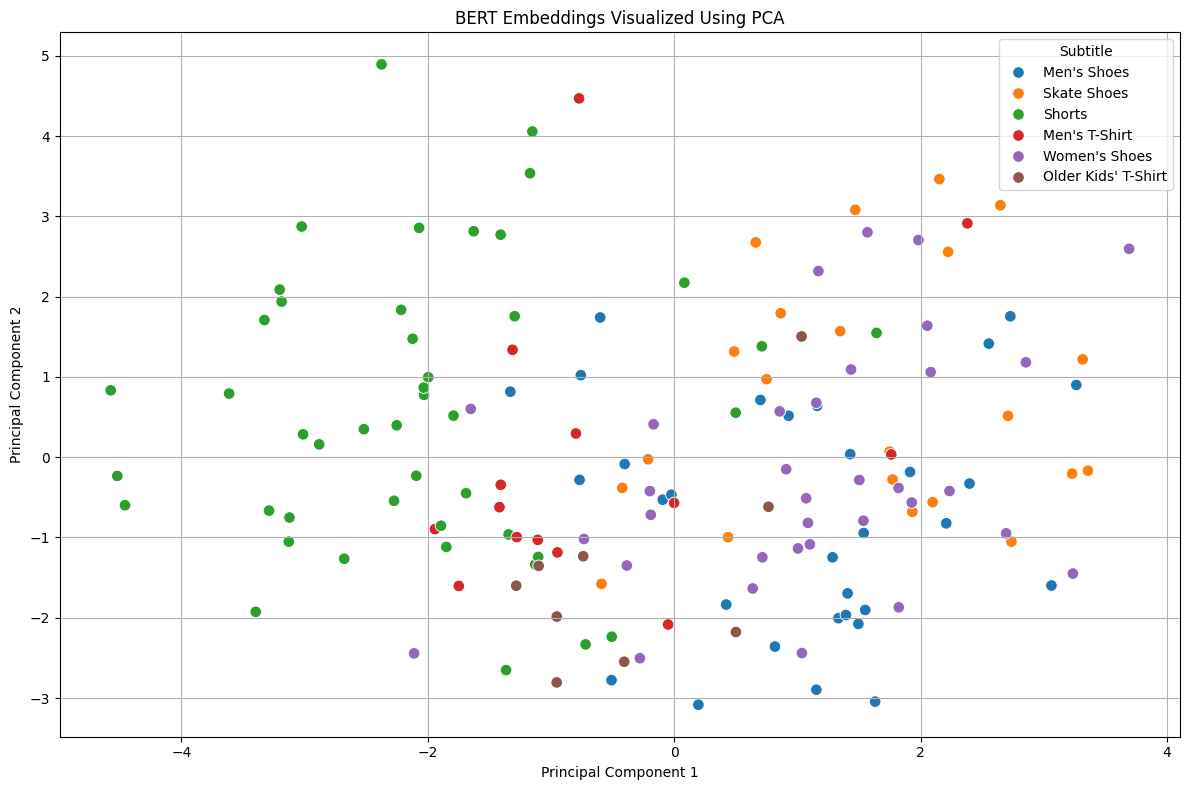

In [43]:
# 8. Plot the PCA-reduced BERT embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='subtitle', palette='tab10', s=70)

plt.title('BERT Embeddings Visualized Using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Subtitle', loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('nike_bert_pca.png')
plt.show()
